In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, \
    balanced_accuracy_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, \
    StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Plot styling.
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='sans-serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)

In [3]:
compounds = pd.read_csv('../data/compound_features.csv')
features = compounds[['MW', 'SA', 'LogP']]
clss = compounds['Skin']

In [4]:
# Repeatedly evaluate the model to estimate its performance.
n_splits = 100
test_size = 0.2
accuracies_train = np.empty(n_splits, np.float32)
accuracies_test = np.empty(n_splits, np.float32)
average_precisions_train = np.empty(n_splits, np.float32)
average_precisions_test = np.empty(n_splits, np.float32)
roc_aucs_train = np.empty(n_splits, np.float32)
roc_aucs_test = np.empty(n_splits, np.float32)
interval = np.linspace(0, 1, 101, dtype=np.float32)
tprs_train = np.empty((n_splits, 101), np.float32)
tprs_test = np.empty((n_splits, 101), np.float32)
precisions_train = np.empty((n_splits, 101), np.float32)
precisions_test = np.empty((n_splits, 101), np.float32)
feature_importances = np.zeros((n_splits, len(features.columns.values)),
                               np.float32)
best_params = []
for i, (train_index, test_index) in enumerate(
        StratifiedShuffleSplit(
            n_splits, test_size=test_size, random_state=42).split(
            features.values, clss)):
    features_train, features_test = (features.values[train_index],
                                     features.values[test_index])
    clss_train, clss_test = clss[train_index], clss[test_index]
    
    classifier = GridSearchCV(
        Pipeline([('scale', StandardScaler()),
                  ('classify', LogisticRegression(
                      class_weight='balanced', random_state=42))]),
        param_grid={'classify__C': [0.01, 0.1, 1, 10, 100, 1000]},
        n_jobs=-1,
        cv=StratifiedShuffleSplit(n_splits, test_size=test_size,
                                  random_state=42))
    
    classifier.fit(features_train, clss_train)
    pred_train = classifier.predict_proba(features_train)[:, 1]
    pred_test = classifier.predict_proba(features_test)[:, 1]
    
    # Compute evaluation metrics on the train and test data.
    accuracies_train[i] = balanced_accuracy_score(
            clss_train, np.asarray(pred_train > 0.5, np.int))
    accuracies_test[i] = balanced_accuracy_score(
            clss_test, np.asarray(pred_test > 0.5, np.int))
    average_precisions_train[i] = average_precision_score(
        clss_train, pred_train)
    average_precisions_test[i] = average_precision_score(
        clss_test, pred_test)
    roc_aucs_train[i] = roc_auc_score(clss_train, pred_train)
    roc_aucs_test[i] = roc_auc_score(clss_test, pred_test)
    fpr_train, tpr_train, _ = roc_curve(clss_train, pred_train)
    tprs_train[i] = np.interp(interval, fpr_train, tpr_train)
    fpr_test, tpr_test, _ = roc_curve(clss_test, pred_test)
    tprs_test[i] = np.interp(interval, fpr_test, tpr_test)
    precision_train, recall_train, _ = precision_recall_curve(
        clss_train, pred_train)
    precisions_train[i] = np.interp(
        interval, recall_train[::-1], precision_train[::-1])
    precision_test, recall_test, _ = precision_recall_curve(
        clss_test, pred_test)
    precisions_test[i] = np.interp(
        interval, recall_test[::-1], precision_test[::-1])
    
    # Feature importances.
    feat_imp = permutation_importance(
        classifier, features_train, clss_train, n_jobs=-1, random_state=42)
    feature_importances[i] = feat_imp.importances_mean
    
    # Save optimal hyperparameter(s).
    best_params.append(classifier.best_estimator_.named_steps['classify'].C)
    

stats = {'accuracy_train': np.mean(accuracies_train),
         'accuracy_std_train': np.std(accuracies_train),
         'average_precision_train': np.mean(average_precisions_train),
         'average_precision_std_train': np.std(average_precisions_train),
         'roc_auc_train': np.mean(roc_aucs_train),
         'roc_auc_std_train': np.std(roc_aucs_train),
         'tpr_mean_train': np.mean(tprs_train, axis=0),
         'tpr_std_train': np.std(tprs_train, axis=0),
         'precision_mean_train': np.mean(precisions_train, axis=0),
         'precision_std_train': np.std(precisions_train, axis=0),
        
         'accuracy_test': np.mean(accuracies_test),
         'accuracy_std_test': np.std(accuracies_test),
         'average_precision_test': np.mean(average_precisions_test),
         'average_precision_std_test': np.std(average_precisions_test),
         'roc_auc_test': np.mean(roc_aucs_test),
         'roc_auc_std_test': np.std(roc_aucs_test),
         'tpr_mean_test': np.mean(tprs_test, axis=0),
         'tpr_std_test': np.std(tprs_test, axis=0),
         'precision_mean_test': np.mean(precisions_test, axis=0),
         'precision_std_test': np.std(precisions_test, axis=0),
         
         'feature_importances': np.mean(feature_importances, axis=0),
         'feature_importances_std': np.std(feature_importances, axis=0)}

In [5]:
print(f'Accuracy: {stats["accuracy_test"]:.3f} ± '
      f'{stats["accuracy_std_test"]:.3f}')
print(f'AUROC: {stats["roc_auc_test"]:.3f} ± '
      f'{stats["roc_auc_std_test"]:.3f}')
print(f'Average precision: {stats["average_precision_test"]:.3f} ± '
      f'{stats["average_precision_std_test"]:.3f}')

Accuracy: 0.662 ± 0.089
AUROC: 0.710 ± 0.098
Average precision: 0.761 ± 0.090


In [6]:
final_params = scipy.stats.mode(best_params)[0][0]
print(f'Optimal regularization (C): {final_params}')

Optimal regularization (C): 100.0


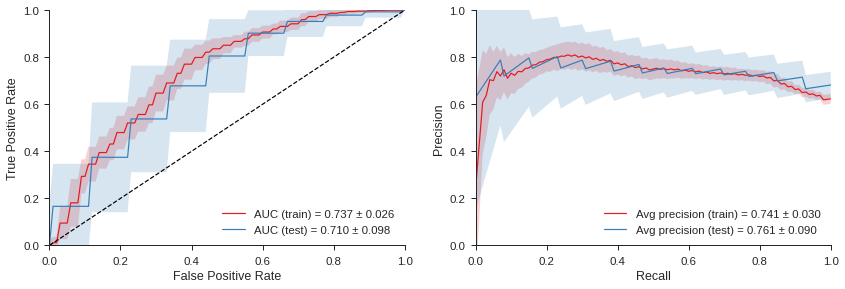

In [7]:
width = 7
height = width / 1.618    # Golden ratio.
fig, axes = plt.subplots(1, 2, figsize=(width * 2, height))

ax = axes[0]
interval = np.linspace(0, 1, 101)
tpr_train = stats['tpr_mean_train']
tpr_train[0], tpr_train[-1] = 0, 1
ax.plot(interval, tpr_train,
        label=f'AUC (train) = {stats["roc_auc_train"]:.3f} '
              f'± {stats["roc_auc_std_train"]:.3f}')
ax.fill_between(interval, tpr_train - stats['tpr_std_train'],
                tpr_train + stats['tpr_std_train'], alpha=0.2)
tpr_test = stats['tpr_mean_test']
tpr_test[0], tpr_test[-1] = 0, 1
ax.plot(interval, tpr_test,
        label=f'AUC (test) = {stats["roc_auc_test"]:.3f} '
              f'± {stats["roc_auc_std_test"]:.3f}')
ax.fill_between(interval, tpr_test - stats['tpr_std_test'],
                tpr_test + stats['tpr_std_test'], alpha=0.2)
        
ax.plot([0, 1], [0, 1], c='black', ls='--')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend(loc='lower right', frameon=False)
        
ax = axes[1]
precision_train = stats['precision_mean_train']
ax.plot(interval, precision_train,
        label=f'Avg precision (train) = '
              f'{stats["average_precision_train"]:.3f} ± '
              f'{stats["average_precision_std_train"]:.3f}')
ax.fill_between(interval, precision_train - stats['precision_std_train'],
                precision_train + stats['precision_std_train'], alpha=0.2)
precision_test = stats['precision_mean_test']
ax.plot(interval, precision_test,
        label=f'Avg precision (test) = '
              f'{stats["average_precision_test"]:.3f} ± '
              f'{stats["average_precision_std_test"]:.3f}')
ax.fill_between(interval, precision_test - stats['precision_std_test'],
                precision_test + stats['precision_std_test'], alpha=0.2)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

ax.legend(loc='lower right', frameon=False)

sns.despine()

plt.savefig('roc.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

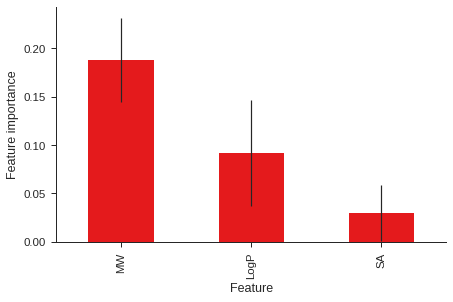

In [8]:
width = 7
height = width / 1.618    # Golden ratio.
fig, ax = plt.subplots(figsize=(width, height))

feature_importances = pd.DataFrame(
    {'feature_importance': stats['feature_importances'],
     'std': stats['feature_importances_std']},
    index=features.columns.values)
feature_importances = feature_importances.sort_values(
    'feature_importance', ascending=False).head(20)
feature_importances['feature_importance'].plot.bar(
    yerr=feature_importances['std'], legend=False, ax=ax)

ax.set_ylim(0, ax.get_ylim()[1])

ax.set_xlabel('Feature')
ax.set_ylabel('Feature importance')

sns.despine()

plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [9]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('classify', LogisticRegression(C=final_params, class_weight='balanced',
                                    random_state=42))])
train_sizes, train_scores, test_scores = learning_curve(
    model, features.values, clss, train_sizes=np.linspace(0.2, 1.0, 10),
    cv=StratifiedShuffleSplit(100, test_size=0.2, random_state=42),
    scoring='roc_auc', n_jobs=-1)

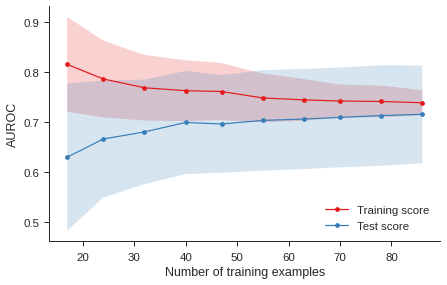

In [10]:
width = 7
height = width / 1.618    # Golden ratio.
fig, ax = plt.subplots(figsize=(width, height))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
ax.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2)
ax.plot(train_sizes, test_scores_mean, 'o-', label='Test score')
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2)

ax.set_xlabel('Number of training examples')
ax.set_ylabel('AUROC')

ax.legend(loc='lower right', frameon=False)

sns.despine()

plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()